In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

import sys
from pathlib import Path
sys.path.insert(0, str(Path("..").resolve()))

from utils import sample_batch, display

In [2]:
img_size = 16
pixel_levels = 4
n_filters = 128
residual_blocks = 5
batch_size = 128
epochs = 30 # 150
l_rate=0.0005

In [3]:
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

### Preprocess the data

In [ ]:
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (img_size, img_size)).numpy()
    imgs_int = (imgs_int / (256 / pixel_levels)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / pixel_levels
    return imgs, imgs_int

input_data, output_data = preprocess(x_train)

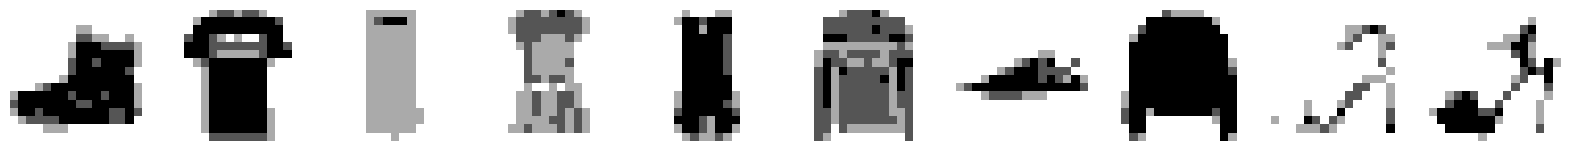

In [5]:
display(input_data)

### Model

In [20]:
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        self.conv.build(input_shape)
        kernel_shape = self.conv.kernel.shape
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)
    
    def get_config(self):
        cfg = super().get_config()
        return cfg

In [21]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(filters=filters//2, kernel_size=1, activation="relu")
        self.pixel_cnn_conv = MaskedConv2D(mask_type="B", filters=filters//2, kernel_size=3, activation="relu", padding="same")
        self.conv2 = layers.Conv2D(filters=filters, kernel_size=1, activation="relu")

    def call(self, inputs):
        x=self.conv1(inputs)
        x=self.pixel_cnn_conv(x)
        x=self.conv2(x)
        return layers.add([inputs, x])
    
    def get_config(self):
        cfg = super().get_config()
        return cfg

In [22]:
inputs = layers.Input(shape=(img_size, img_size, 1))
x = MaskedConv2D(mask_type="A", filters=n_filters, kernel_size=7, activation="relu", padding="same")(inputs)

for _ in range(residual_blocks):
    x = ResidualBlock(filters=n_filters)(x)

for _ in range(2):
    x = MaskedConv2D(mask_type="B", filters=n_filters, kernel_size=1, strides=1, activation="relu", padding="valid")(x)

out = layers.Conv2D(filters=pixel_levels, kernel_size=1, strides=1, activation="softmax", padding="valid")(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_14 (MaskedConv2D) │ (None, 16, 16, 128)    │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_7                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_8                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_9                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_10               │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_11               │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_20 (MaskedConv2D) │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_21 (MaskedConv2D) │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 16, 16, 4)      │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,460 (1.17 MB)

 Trainable params: 307,460 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [23]:
adam = optimizers.Adam(learning_rate=l_rate)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [24]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature): 
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)
    
    def generate(self, temperature):
        generated_images = np.zeros(shape=(self.num_img,) + (pixel_cnn.input_shape)[1:])
        batch, rows, cols, channels = generated_images.shape
        
        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[:, row, col, :]
                    generated_images[:, row, col, channel] = [self.sample_from(x, temperature) for x in probs]
                    generated_images[:, row, col, channel] /= pixel_levels

        return generated_images
    
img_generator_callback = ImageGenerator(num_img=10)

In [25]:
def on_epoch_end(self, epoch, logs=None):
    generated_images = self.generate(temperature=1.0)
    display(generated_images)

In [26]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=[tensorboard_callback, img_generator_callback],
)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 150s 307ms/step - loss: 0.4915
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 160s 342ms/step - loss: 0.3969
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 169s 360ms/step - loss: 0.3859
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 302ms/step - loss: 0.3792
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 299ms/step - loss: 0.3747
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 134s 286ms/step - loss: 0.3713
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 177s 376ms/step - loss: 0.3682
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 232s 494ms/step - loss: 0.3654
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 250s 468ms/step - loss: 0.3633
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 223s 476ms/step - loss: 0.3615
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 223s 475ms/step - loss: 0.3596
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 234s 500ms/step - loss: 0.3577
Epoch 13/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 226s 481ms/step - loss: 0.3558
Epoch 14/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 228s 485ms/step - loss: 0.3544
E

### Generate new images

In [27]:
generated_images = img_generator_callback.generate(temperature=1.0)

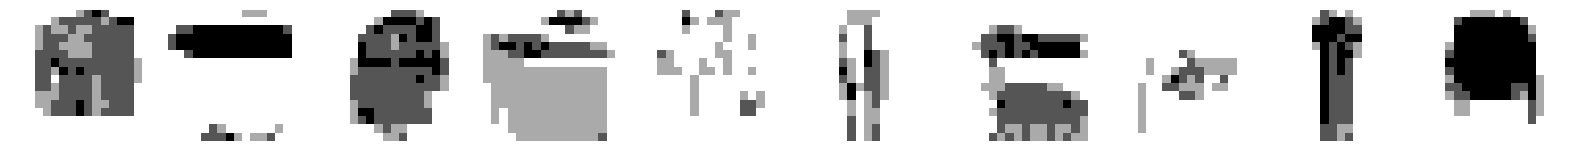

In [28]:
display(generated_images)